# TP 4

## Ejercicio 1

Los sistemas de procesamiento digital de señales (DSP) modernos son capaces de realizar enormes
cantidades de cálculos en tiempo real, tanto en formatos de punto fijo como flotante. Describa con
sus palabras cuáles son las ventajas del punto fijo respecto al flotante y viceversa en relación a:

* Costo de hardware.
* Eficiencia energética.
* Facilidad de implementación de algoritmos.
* Velocidad de cálculos.


## Ejercicio 2

Exprese $5/8$, $9/16$, $-5/8$ y $-9/16$ en formato signo-magintud, complemento a uno y complemento a
dos, para ello complete la siguiente tabla:

| Número decimal | Signo-Magnitud | Complemento a 1 | Complemento a 2 |
|:--------------:|:--------------:|:---------------:|:---------------:|
|      $5/8$     |                |                 |                 |
|      $9/6$     |                |                 |                 |
|     $-5/8$     |                |                 |                 |
|     $-9/6$     |                |                 |                 |

### Resolución


In [2]:
5/8*2**3

5.0

In [3]:
from utils.misc import init_sp_printing
import sympy as sp
init_sp_printing(sp)

nums = [sp.S(num) for num in ["5/8", "9/6", "-5/8", "-9/6"]]
nums

In [4]:
from typing import Optional

def to_bin_exact(expr) -> Optional[tuple[int, int]]:
    expr = sp.Rational(expr)
    places = sp.log(sp.denom(expr), 2)
    if not places.is_Integer:
        return None
    return int(sp.numer(expr)), int(places)

def split_before(indexable, at):
    return indexable[:at], indexable[at:]

def display_fxp(base: int, places: int):
    numer_str = f"{base:0{places+1}b}"
    return ".".join(
        split_before(numer_str, len(numer_str)-places))


In [5]:
fxps = [(*to_bin_exact(num),) for num in nums]

[]

## Ejercicio 5

Dada la siguiente función de transferencia, analizar gráficamente que ocurre con los polos del sistema
al implementarse en un DSP de 8 bits. Graficar utilizando Matlab el diagrama de polos y ceros original
y el implementado en el DSP. ¿Es estable el sistema implementado?

$$
H(z) = \frac{4}{
    (1+0.97z^{-1})(1+0.98z^{-1})(1+0.99z^{-1})
}
$$

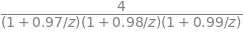

In [6]:
z = sp.Symbol("z")

h_z_ = sp.sympify("4/((1+0.97/z)*(1+0.98/z)*(1+0.99/z))")
h_z_

In [7]:
from control import matlab as m
from fxpmath import Fxp
import numpy as np

z_dtf = m.tf("z")

h_z_dtf = sp.lambdify(z, h_z_)(z_dtf)
h_z_dtf

TransferFunction(array([4, 0, 0, 0]), array([1.      , 2.94    , 2.8811  , 0.941094]), True)

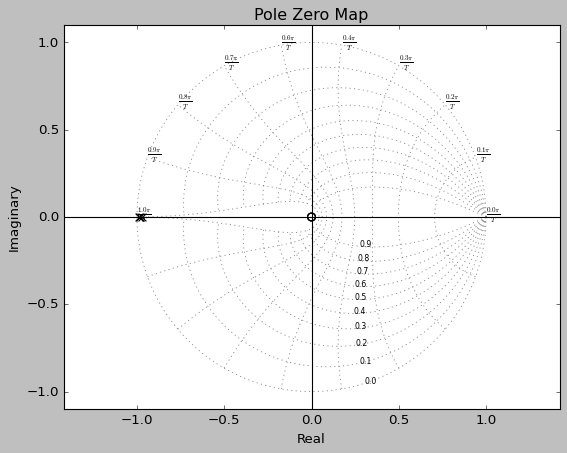

In [8]:
from matplotlib import pyplot as plt

with plt.style.context("classic"):
    m.pzmap(h_z_dtf, plot=True, grid=True)

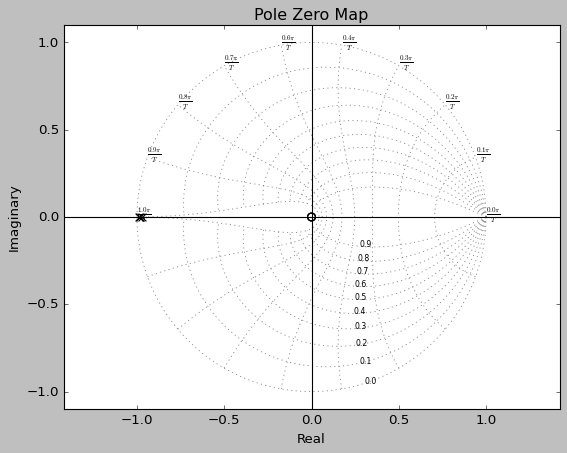

In [9]:
with plt.style.context("classic"):
    m.pzmap(h_z_dtf, plot=True, grid=True)

In [10]:
Fxp("1.2", signed=True, dtype="Q3.5")

fxp-s8/5(1.1875)

## Ejercicio 6

El siguiente diagrama recursivo debe simularse para determinar el rango de valores posibles en sus
variables internas, y así obtener la representación en 5 bits y formato Q de punto fijo que mejor
resolución permita.

![](./res/tp4/ej6/sys.png)

Suponiendo que la señal de entrada $x[n]$ es un escalón causal de amplitud $0.5$, se pide:

1) Simular manualmente o en Matlab las primeras 4 salidas del sistema utilizando punto flotante.
2) Hacer lo mismo que en el punto anterior solamente que en punto fijo (con el punto donde
determine que mejor resolución permita) y utilizando 5 bits con signo y truncando el resultado
de las multiplicaciones.
3) Grafique la salida ideal y la cuantificada ¿Qué error porcentual se produce?

In [11]:
from numba import jit, njit
from numba.experimental import jitclass
import fxpmath

def p6_sim(xs):
    y_m1 = 0
    ys = xs*0
    for i in range(len(xs)):
        y_m1 = y_m1 * 1/4 + xs[i]
        ys[i] = y_m1
    return ys

In [12]:
p6_sim(Fxp(np.ones(4)*0.5, signed=True, dtype="Q1.4"))

fxp-s5/4([0.5    0.9375 0.9375 0.6875])

## Ejercicio 8

El siguiente sistema digital debe implementarse en un Arduino Nano, cuyas capacidades de cómputo
están limitadas a punto fijo de 16 bits. Si la señal de entrada proviene del muestreo de la señal de
tensión de una red, y oscila entre los $16$ y $-16 \mathrm{V}$ con un offset de $8\mathrm{V}$, determinar cuál es el
mejor formato de representación en punto fijo que permite que la salida $y(n)$ y las variables de cálculo
internas se representen con el menor error posible. $B_1=0,3$; $B_2=0,4$; $B_3=0,1$ $A_1=-0,1$; $A_2=-0,8$.

In [13]:

from typing import Callable, TypeVar
from dataclasses import dataclass, field


b = [0.3, 0.4, 0.1]
a = [-0.1, -0.8]

T = TypeVar("T")

def report_dot(a: T, b: T, report: Callable[[T], T]) -> T:
    """
    Hace el producto punto entre `a` y `b` reportando
    los valores intermedios intermedios 
    """
    sum = np.cumsum(report(np.multiply(a, b)))
    report(sum[1:])
    return sum[-1]

T = TypeVar("T")

def pad_right_same(a: T, b: T) -> tuple[T, T]:
    """
    Agrega ceros (padding) a la derecha de forma que
    ambos vectores tengan la misma longitud
    """
    diff = len(a) - len(b)
    return (a, np.pad(b, (0, diff))
    ) if diff > 0 else (
        np.pad(a, (0, -diff)), b)

T = TypeVar("T")

def sim(a: T, b: T, xs: T, report: Callable[[T], T] = lambda x: x) -> T:
    """
    Simula un sistema en ecuaciones a diferencias para cierta entrada,
    reportando los valores intermedios a las operaciones aritméticas
    """
    a, b, xs = map(np.asanyarray, [a, b, xs])
    ys = xs*0
    [*map(report, (a, b, xs))]
    a, b = pad_right_same(np.pad(a, (1, 0)), b)
    pad = len(a) - 1
    ys = np.pad(ys, (pad, 0))
    xs = np.pad(xs, (pad, 0))
    for i in range(pad, len(xs)):
        ys[i] = report(
            report_dot(
                b[::-1],
                xs[i-pad:i+1],
                report
            ) + report_dot(
                a[::-1],
                ys[i-pad:i+1],
                report
            )
        )
    return ys[pad:]


In [14]:
from collections import Counter

@dataclass(frozen=True)
class Reporter:
    width: float = 1.
    counter: Counter = field(default_factory=Counter)
    
    def update(self, nums_):
        """
        Actualiza de forma eficiente las
        ocurrencias de los valores dentro de los rangos
        establecidos mediante `width`
        """
        nums = np.asanyarray(nums_ if not np.isscalar(nums_) else [nums_])
        self.counter.update(
            np.around(nums/self.width)*self.width
        )
        return nums_


In [19]:
reporter = Reporter(width=4)

offset, ampl = 8, 16
# Toma alrededor de 30 segundos para 800k muestras en mi pc, crece de forma lineal
sim(a, b, np.random.uniform(offset-ampl, offset+ampl, size=800000), report=reporter.update)


array([ 3.60605641,  4.65000861,  4.89691694, ..., -1.9514223 ,
       -2.11934141,  6.45010957])

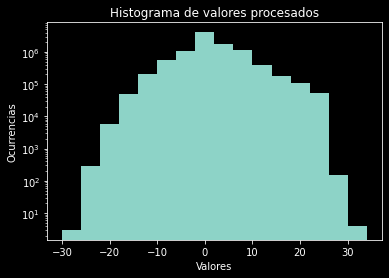

In [42]:
plt.title("Histograma de valores procesados")
plt.ylabel("Ocurrencias")
plt.xlabel("Valores")
plt.bar(
    reporter.counter.keys(),
    reporter.counter.values(),
    width=reporter.width
)
plt.gca().set_yscale("log")
min(reporter.counter.keys()), max(reporter.counter.keys())

In [41]:
import math

def min_bin_signed(num):
    return math.ceil(math.log2(abs(num))) + 1

In [40]:
word = 16
min_int = min_bin_signed(np.max(np.abs([*reporter.counter.keys()]))) + 1
print(f"Formato necesario: Q{min_int}.{word-min_int}")

Formato necesario: Q7.9
